In [2]:
%matplotlib inline
import os
import cv2
import seaborn 
import numpy as np
import pandas as pd 
import random
import tqdm
from tqdm import notebook
import albumentations as A
from albumentations import pytorch
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision

In [3]:
images_dir = r'./cityscapes_data'
train_images_dir = os.path.join(images_dir, 'train')
val_images_dir = os.path.join(images_dir, 'val')
working_dir = '/kaggle/working'

weights_path = os.path.join(working_dir, 'unet4_weights.pth')
logs_path = os.path.join(working_dir, 'logs')

In [4]:
class Generator(object):
    def __init__(self, images_dir, batch_size, is_augmentation, shuffle = True, rescale = 1.00, target_size = (128, 128)):
        super(Generator, self).__init__()
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.rescale = rescale
        self.shuffle = shuffle
        self.is_augmentation = is_augmentation
        self.target_size = target_size
        self.filenames = [os.path.join(self.images_dir, filename) for filename in os.listdir(self.images_dir)]
        self.current_step = 0
        self.count_images = len(self.filenames)
        self.available_steps = int(self.count_images // self.batch_size)
        self.transforms = A.Compose([
            A.Rotate(25), 
            A.OneOf([
                A.RGBShift(), A.HueSaturationValue()
            ]),
            A.OneOf([
                A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()
            ]), 
        ])
    
    def augmentate(self, batch):
        batch = batch.astype(np.uint8)
        batch = [self.transforms(image = image, mask = mask) for (image, mask) in batch]
        batch = np.array([(transformed['image'], transformed['mask']) for transformed in batch], dtype = np.float32)
        return batch

    def generate_batch(self):
        start = self.current_step * self.batch_size
        stop = (self.current_step + 1) * self.batch_size
        filenames_batch = self.filenames[start:stop]
        
        # batch of original images from directory
        images_batch = [cv2.imread(filename) for filename in filenames_batch]
        
        # change channeld order to rgb
        images_batch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_batch])
        
        # split original images by image and mask
        images_batch = np.array([(image[:, :256,], image[:, 256:]) for image in images_batch]) 
        
        # resize images 
        images_batch = np.array([(cv2.resize(image, self.target_size), cv2.resize(mask, self.target_size)) for (image, mask) in images_batch], dtype = np.float32)
        # augmentation
        if self.is_augmentation:
            images_batch = self.augmentate(images_batch)
        
         # set 'channel_first' order
        images_batch = np.array([(np.moveaxis(image, -1, 0), np.moveaxis(mask, -1, 0)) for (image, mask) in images_batch])
        
        # rescaling 
        images_batch /= self.rescale
        #resampling 
        images_batch = np.moveaxis(images_batch, 1, 0)
        
        return torch.Tensor(images_batch)
    
    def __next__(self):
        if self.current_step > self.available_steps:
            self.current_step = 0
        images, masks = self.generate_batch()
        self.current_step += 1
        return images, masks

    def __len__(self):
        return self.available_steps
        

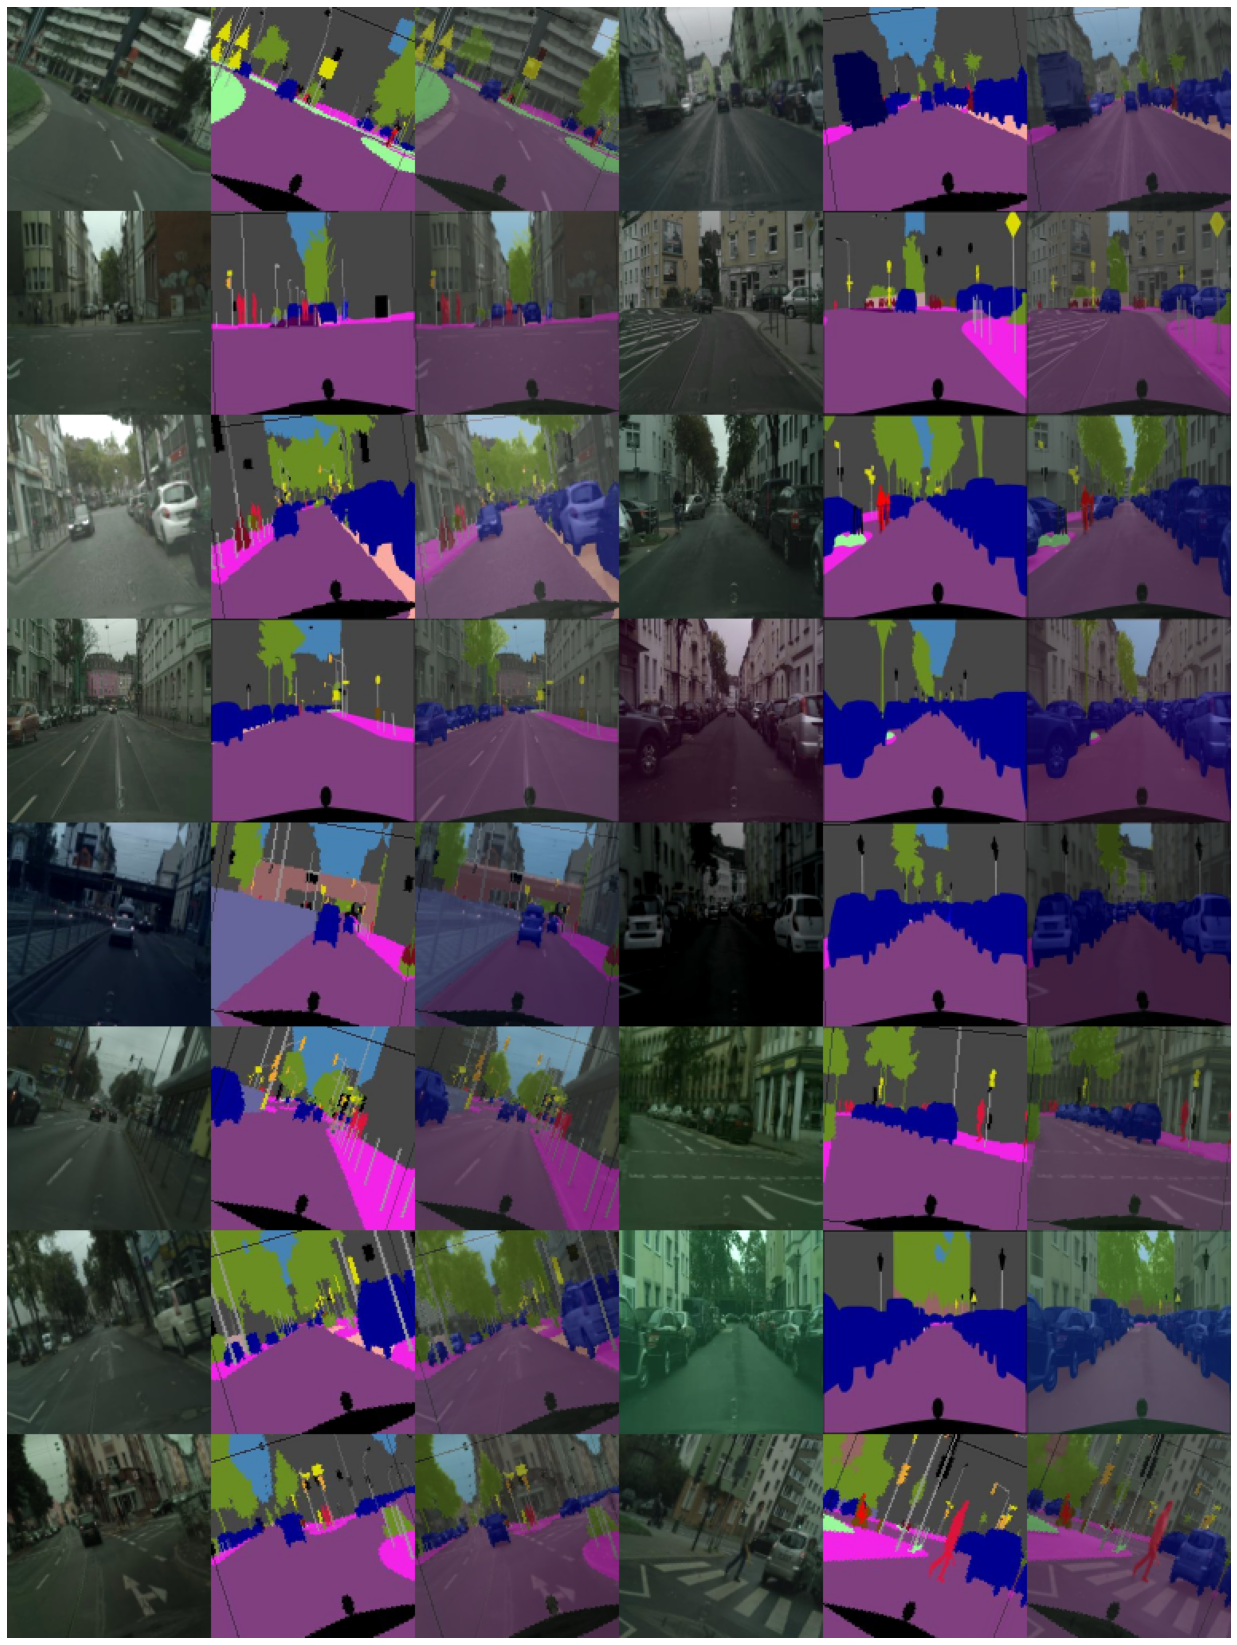

In [5]:
def show_examples(num_cols):
    stacks = []
    dataloader = Generator(images_dir = train_images_dir, batch_size = 8, is_augmentation = True, rescale = 255.0)
    for iteration in range(num_cols):
        images, masks = next(dataloader)
        images, masks = images.numpy(), masks.numpy()
        images, masks = np.concatenate(np.moveaxis(images, 1, -1)), np.concatenate(np.moveaxis(masks, 1, -1))
        embedded = (images + masks) / 2
        stack = np.hstack([images, masks, embedded])
        stacks.append(stack)
    result = np.hstack(stacks)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)

show_examples(2)

In [12]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2, x3=None):
        x1 = self.up(x1)
        # input is CHW

        if x3 != None:
            x = torch.cat([x3, x2, x1], dim=1)
        else:
            x = torch.cat([x2, x1], dim=1)

        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)




class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1088, 512 // factor, bilinear)
        self.up2 = Up(640, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

        self.down1_1 = nn.MaxPool2d(8)
        self.down2_2 = nn.MaxPool2d(2)
        #self.up3_3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #self.up4_4 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)



    def forward(self, x):
        x1 = self.inc(x)
        x1_1 = self.down1_1(x1)
        x2 = self.down1(x1)
        x2_2 = self.down2_2(x2)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4, x1_1)
        x = self.up2(x, x3, x2_2)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits  

In [13]:
unet = UNet(n_channels=3, n_classes=3, bilinear=True)
x = torch.zeros(8, 3, 128, 128, dtype=torch.float, requires_grad=False)
out = unet(x)

In [16]:
train_generator = Generator(images_dir = train_images_dir, batch_size = 32, is_augmentation = True, rescale = 255.0)
train_images, train_masks = next(train_generator)
print("generation of images completed")

print(len(train_generator))
train_images, train_masks = next(train_generator)
print(train_images.size())
print(train_images.size(0))
out = unet(train_images)

generation of images completed
92
torch.Size([32, 3, 128, 128])
32


In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = nn.functional.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


In [26]:
optimizer = torch.optim.Adam(params = unet.parameters(), 
                             lr=1e-4, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=0, 
                             amsgrad=False)

criterion = DiceBCELoss()

def dice_coeff(pred, target):
    pred = (pred > 0).float()
    return 2. * (pred*target).sum() / (pred+target).sum()

def training(model, epochs, batch_size):

    train_generator = Generator(images_dir = train_images_dir, batch_size = batch_size, is_augmentation = True, rescale = 255.0)
    test_generator = Generator(images_dir = val_images_dir, batch_size = batch_size, is_augmentation = False, rescale = 255.0)
    
    device = torch.device('cpu')
    model.to(device)

    valid_loss_min = np.Inf

    for epoch in range(1, epochs+1):

        train_loss_avg = 0.0
        test_loss_avg = 0.0
        train_dice_coeff = 0.0
        test_dice_coeff = 0.0

        #Model Training

        model.train()
        for i in range(len(train_generator)):
            train_images, train_masks = next(train_generator)
            train_images, train_masks = train_images.to(device), train_masks.to(device)
            
            optimizer.zero_grad()
            
            train_predictions = model(train_images)
            
            train_loss = criterion(train_predictions, train_masks)
            
            train_loss.backward()

            train_dice_coeff += dice_coeff(pred = train_predictions, target = train_masks)
            
            optimizer.step()
            
            train_loss_avg += train_loss.item()

            torch.cuda.empty_cache()
        
        
            
        #Model Validation

        model.eval()
        for i in range(len(test_generator)):

            test_images, test_masks = next(test_generator)
            test_images, test_masks = test_images.to(device), test_masks.to(device)

            test_predictions = model(test_images)

            test_loss = criterion(test_predictions, test_masks)

            test_dice_coeff += dice_coeff(pred = test_predictions, target = test_masks)

            test_loss_avg += test_loss.item()

            torch.cuda.empty_cache()
        
        # calculate average losses and dice coeff
        train_loss_avg = train_loss_avg/len(train_generator)
        train_dice_coeff = train_dice_coeff/len(train_generator)

        test_loss_avg = test_loss_avg/len(test_generator)
        test_dice_coeff = test_dice_coeff/len(test_generator)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Dice Coeffienct: {:.6f} \tTest Loss: {:.6f} \tTest Dice Coeffienct: {:.6f} '.format(
            epoch, train_loss_avg, train_dice_coeff ,test_loss_avg, test_dice_coeff))
        
        # save model
        torch.save(model.state_dict(), 'model_mod.pt')
        

torch.cuda.empty_cache()

training(model = unet, epochs = 10, batch_size = 32)

Epoch: 1 	Training Loss: 0.594503 	Training Dice Coeffienct: 0.478840 	Test Loss: 0.584937 	Test Dice Coeffienct: 0.490384 
Epoch: 2 	Training Loss: 0.586145 	Training Dice Coeffienct: 0.467435 	Test Loss: 0.581325 	Test Dice Coeffienct: 0.495658 
Epoch: 3 	Training Loss: 0.581967 	Training Dice Coeffienct: 0.460245 	Test Loss: 0.577757 	Test Dice Coeffienct: 0.478365 
Epoch: 4 	Training Loss: 0.579067 	Training Dice Coeffienct: 0.460719 	Test Loss: 0.573901 	Test Dice Coeffienct: 0.467391 
Epoch: 5 	Training Loss: 0.575595 	Training Dice Coeffienct: 0.471747 	Test Loss: 0.571658 	Test Dice Coeffienct: 0.435904 
Epoch: 6 	Training Loss: 0.574100 	Training Dice Coeffienct: 0.468744 	Test Loss: 0.569950 	Test Dice Coeffienct: 0.432458 
Epoch: 7 	Training Loss: 0.572250 	Training Dice Coeffienct: 0.470921 	Test Loss: 0.565971 	Test Dice Coeffienct: 0.440190 
Epoch: 8 	Training Loss: 0.570089 	Training Dice Coeffienct: 0.471742 	Test Loss: 0.566239 	Test Dice Coeffienct: 0.444916 


In [9]:
model = UNet(n_channels=3, n_classes=3, bilinear=True)
model.load_state_dict(torch.load("model.pt"))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): B

tensor(0.4549)
tensor(0.4366)


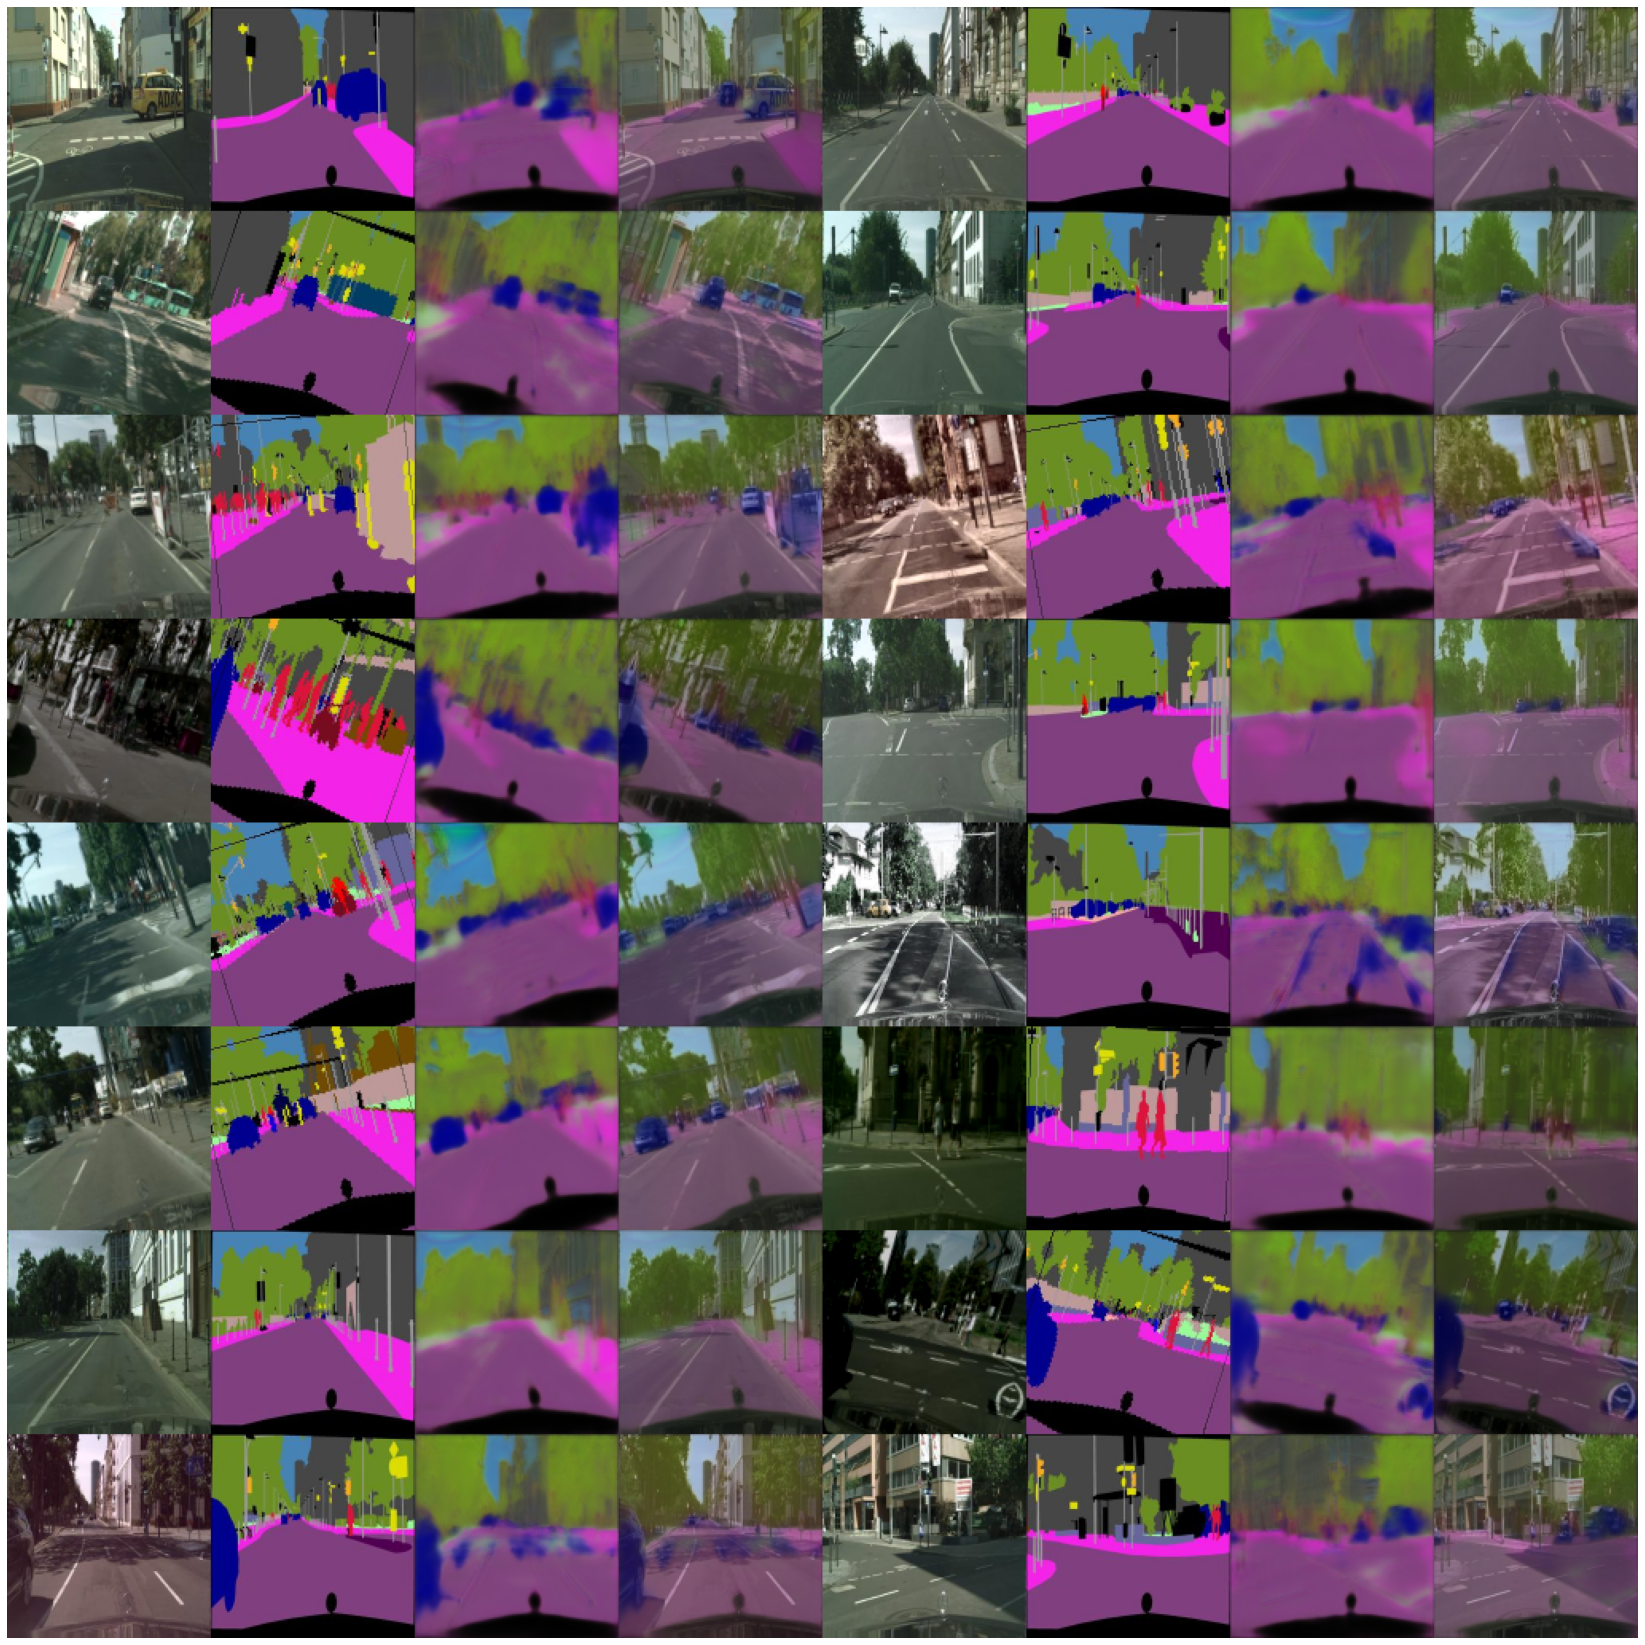

In [11]:
def show_final_results(num_cols):
    generator = Generator(images_dir = val_images_dir, 
                           batch_size = 8, 
                           is_augmentation = True, 
                           rescale = 255.0)
    result = []
    for iteration in range(num_cols):
        images, masks = next(generator)
        prediction = model(images)
        dc = dice_coeff(pred = prediction, target = masks)
        print(dc)
        prediction = torch.sigmoid(prediction)
        prediction = prediction.cpu().detach().numpy()
        prediction = np.moveaxis(prediction, 1, -1)
        masks = np.moveaxis(masks.numpy(), 1, -1)
        images = np.moveaxis(images.numpy(), 1, -1)
        prediction = np.concatenate(prediction)
        images = np.concatenate(images)
        masks = np.concatenate(masks)
        merged = np.add(images, prediction) / 2
        outputs = np.hstack([images, masks, prediction, merged])
        result.append(outputs)
        
    result = np.hstack(result)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)
    
show_final_results(num_cols = 2)